## Applying Faster R-CNN for Object Detection on Malaria Images

https://data.broadinstitute.org/bbbc/BBBC041/

https://arxiv.org/abs/1804.09548

Deep learning based models have had great success in object detection, butthe state of the art models have not yet been widely applied to biologicalimage data. We apply for the first time an object detection model previouslyused on natural images to identify cells and recognize their stages inbrightfield microscopy images of malaria-infected blood. Many micro-organismslike malaria parasites are still studied by expert manual inspection and handcounting. This type of object detection task is challenging due to factors likevariations in cell shape, density, and color, and uncertainty of some cellclasses. In addition, annotated data useful for training is scarce, and theclass distribution is inherently highly imbalanced due to the dominance ofuninfected red blood cells. We use Faster Region-based Convolutional NeuralNetwork (Faster R-CNN), one of the top performing object detection models inrecent years, pre-trained on ImageNet but fine tuned with our data, and compareit to a baseline, which is based on a traditional approach consisting of cellsegmentation, extraction of several single-cell features, and classificationusing random forests. To conduct our initial study, we collect and label adataset of 1300 fields of view consisting of around 100,000 individual cells.We demonstrate that Faster R-CNN outperforms our baseline and put the resultsin context of human performance.

#### Input Files

Content
Images are in .png or .jpg format. There are 3 sets of images consisting of 1364 images (~80,000 cells) with different researchers having prepared each one: from Brazil (Stefanie Lopes), from Southeast Asia (Benoit Malleret), and time course (Gabriel Rangel). Blood smears were stained with Giemsa reagent.

Labels
The data consists of two classes of uninfected cells (RBCs and leukocytes) and four classes of infected cells (gametocytes, rings, trophozoites, and schizonts). Annotators were permitted to mark some cells as difficult if not clearly in one of the cell classes. The data had a heavy imbalance towards uninfected RBCs versus uninfected leukocytes and infected cells, making up over 95% of all cells.

A class label and set of bounding box coordinates were given for each cell. For all data sets, infected cells were given a class label by Stefanie Lopes, malaria researcher at the Dr. Heitor Vieira Dourado Tropical Medicine Foundation hospital, indicating stage of development or marked as difficult.

Input files are provided in JSON format for train and test data. Images are in .png format which has train and test images combined.

Files:

train.json - Train data in JSON format

test.json - Test data in JSON format

Images - Train and test images in .png format

##### Columns in both train and test

a. Checksum - ID

b. pathame - path of the image 

c. ShapeR - shapeR of the image

d. ShapeC - ShapeC of the image

e. channels - channels of the image

f. bbminR - bounding box co-ordinates minR

g. bbminC - bounding box co-ordinates minC

h. bbmaxR - bounding box co-ordinates maxR

i. bbmaxC - bounding box co-ordinates maxC

j. category - class of the objects in the image

### Data Analysis

##### Importing required Libraries

In [1]:
import numpy as np
import time
import sys
import os
import random
#from skimage import io
import pandas as pd
from matplotlib import pyplot as plt
from shutil import copyfile

import cv2
import tensorflow as tf

#### Converting train and test json files to csv files

In [7]:
import json
import csv

#https://pythonbasics.org/read-json-file/
#https://www.programiz.com/python-programming/writing-csv-files

# read file
with open('train.json', 'r') as myfile:
    data=myfile.read()

# parse file
objlist = json.loads(data)
_list = []
for obj in objlist:
        _imageRow = []
        img = obj['image']
        _imageRow.append(img['checksum'])
        _imageRow.append(img['pathname'])
        shp = img['shape']
        _imageRow.append(shp['r'])
        _imageRow.append(shp['c'])
        _imageRow.append(shp['channels'])

        boundObjs = obj['objects']
        for boundObj in boundObjs:
            _bondBox = []
            
            bbox = boundObj['bounding_box']
            bmin = bbox['minimum']
            _bondBox.append(bmin['r'])
            _bondBox.append(bmin['c'])
            
            bmax = bbox['maximum']
            _bondBox.append(bmax['r'])
            _bondBox.append(bmax['c'])
            _bondBox.append(boundObj['category'])
            
            #Prepare record
            _newRow = []
            for r in _imageRow:
                _newRow.append(r)
            for r in _bondBox:        
                _newRow.append(r)
            _bondBox.remove
            _list.append(_newRow)
        _imageRow.remove            
#print(_list)
with open('train.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['checksum', 'pathname', 'shapeR' , 'shapeC', 'channels', 'bbminR', 'bbminC', 'bbmaxR', 'bbmaxC', 'category'])
    writer.writerows(_list)

In [8]:
import json
import csv

#https://pythonbasics.org/read-json-file/
#https://www.programiz.com/python-programming/writing-csv-files

# read file
with open('test.json', 'r') as myfile:
    data=myfile.read()

# parse file
objlist = json.loads(data)
_list = []
for obj in objlist:
        _imageRow = []
        img = obj['image']
        _imageRow.append(img['checksum'])
        _imageRow.append(img['pathname'])
        shp = img['shape']
        _imageRow.append(shp['r'])
        _imageRow.append(shp['c'])
        _imageRow.append(shp['channels'])

        boundObjs = obj['objects']
        for boundObj in boundObjs:
            _bondBox = []
            
            bbox = boundObj['bounding_box']
            bmin = bbox['minimum']
            _bondBox.append(bmin['r'])
            _bondBox.append(bmin['c'])
            
            bmax = bbox['maximum']
            _bondBox.append(bmax['r'])
            _bondBox.append(bmax['c'])
            _bondBox.append(boundObj['category'])
            
            #Prepare record
            _newRow = []
            for r in _imageRow:
                _newRow.append(r)
            for r in _bondBox:        
                _newRow.append(r)
            _bondBox.remove
            _list.append(_newRow)
        _imageRow.remove            
#print(_list)
with open('test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['checksum', 'pathname', 'shapeR' , 'shapeC', 'channels', 'bbminR', 'bbminC', 'bbmaxR', 'bbmaxC', 'category'])
    writer.writerows(_list)

#### Train & Test data Analysis

In [11]:
train=pd.read_csv("train.csv")
print(type(train))
test=pd.read_csv("test.csv")
print("Train Columns",train.columns)
print("Train shape",train.shape)
print("*"*50)
print("Test Columns",test.columns)
print("Test shape",test.shape)

<class 'pandas.core.frame.DataFrame'>
Train Columns Index(['checksum', 'pathname', 'shapeR', 'shapeC', 'channels', 'bbminR',
       'bbminC', 'bbmaxR', 'bbmaxC', 'category'],
      dtype='object')
Train shape (80113, 10)
**************************************************
Test Columns Index(['checksum', 'pathname', 'shapeR', 'shapeC', 'channels', 'bbminR',
       'bbminC', 'bbmaxR', 'bbmaxC', 'category'],
      dtype='object')
Test shape (5922, 10)


In [11]:
train=pd.read_csv("train.csv")
print(type(train))
test=pd.read_csv("test.csv")
print("Train Columns",train.columns)
print("Train shape",train.shape)
print("*"*50)
print("Test Columns",test.columns)
print("Test shape",test.shape)

<class 'pandas.core.frame.DataFrame'>
Train Columns Index(['checksum', 'pathname', 'shapeR', 'shapeC', 'channels', 'bbminR',
       'bbminC', 'bbmaxR', 'bbmaxC', 'category'],
      dtype='object')
Train shape (80113, 10)
**************************************************
Test Columns Index(['checksum', 'pathname', 'shapeR', 'shapeC', 'channels', 'bbminR',
       'bbminC', 'bbmaxR', 'bbmaxC', 'category'],
      dtype='object')
Test shape (5922, 10)


In [12]:
print(train.head(5))

                           checksum  \
0  676bb8e86fc2dbf05dd97d51a64ac0af   
1  676bb8e86fc2dbf05dd97d51a64ac0af   
2  676bb8e86fc2dbf05dd97d51a64ac0af   
3  676bb8e86fc2dbf05dd97d51a64ac0af   
4  676bb8e86fc2dbf05dd97d51a64ac0af   

                                           pathname  shapeR  shapeC  channels  \
0  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
1  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
2  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
3  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
4  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   

   bbminR  bbminC  bbmaxR  bbmaxC        category  
0    1057    1440    1158    1540  red blood cell  
1     868    1303     971    1403  red blood cell  
2     578     900     689    1008  red blood cell  
3     304     611     408     713  red blood cell  
4     198     881 

In [15]:
print(test.head(5))

                           checksum  \
0  eea3bfd6a929bcb06f9786667cd3fbb2   
1  eea3bfd6a929bcb06f9786667cd3fbb2   
2  eea3bfd6a929bcb06f9786667cd3fbb2   
3  eea3bfd6a929bcb06f9786667cd3fbb2   
4  eea3bfd6a929bcb06f9786667cd3fbb2   

                                           pathname  shapeR  shapeC  channels  \
0  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
1  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
2  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
3  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
4  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   

   bbminR  bbminC  bbmaxR  bbmaxC        category  
0     576    1744     708    1883  red blood cell  
1     863    1249     977    1373  red blood cell  
2     210    1573     335    1711  red blood cell  
3    1017    1124    1142    1253  red blood cell  
4     572    1655 

#### Value counts of train and test data

In [14]:
print(train['category'].value_counts())

red blood cell    77420
trophozoite        1473
difficult           441
ring                353
schizont            179
gametocyte          144
leukocyte           103
Name: category, dtype: int64


In [15]:
print(test['category'].value_counts())

red blood cell    5614
ring               169
trophozoite        111
gametocyte          12
schizont            11
difficult            5
Name: category, dtype: int64


#### Train and Test Image Analysis

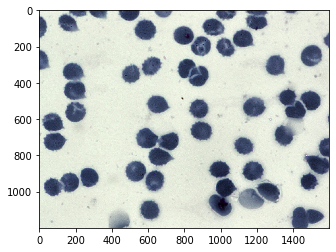

In [29]:
image=plt.imread('images/00a02700-2ea2-4590-9e15-ffc9160fd3de.png')
plt.imshow(image)
plt.show()

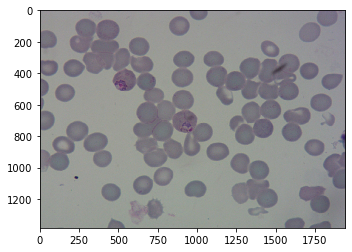

In [4]:
image=plt.imread('Dataset/Open Images Dataset v4 (Bounding Boxes)/test/deab75c9-00bc-488c-8b20-ff4515d85212.jpg')
plt.imshow(image)
plt.show()

#### Train and Test Image Analysis with bounding boxes

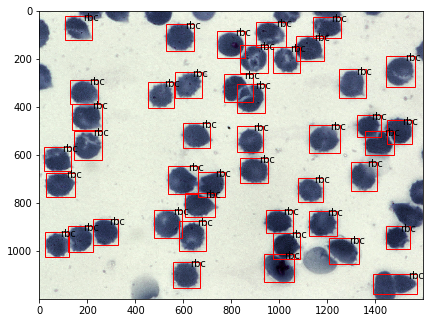

In [30]:
#https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

image = plt.imread('images/00a02700-2ea2-4590-9e15-ffc9160fd3de.png')
plt.imshow(image)


for _,row in train[train.pathname=="/images/00a02700-2ea2-4590-9e15-ffc9160fd3de.png"].iterrows():
    xmin = row.bbminC
    xmax = row.bbmaxC
    ymin = row.bbminR
    ymax = row.bbmaxR
    
    l = xmax-xmin
    b = ymax-ymin
           
    if row.category=='red blood cell':
      color='r'
      ax.annotate('rbc',xy=(xmax-40,ymin+20))
    elif row.category=='trophozoite':
      color='g'
      ax.annotate('trpz',xy=(xmax-40,ymin+20))
    elif row.category=='difficult':
      color='b'
      ax.annotate('dfct',xy=(xmax-40,ymin+20))
    elif row.category=='ring':
      color='r'
      ax.annotate('ring',xy=(xmax-40,ymin+20))
    elif row.category=='schizont':
      color='r'
      ax.annotate('sznt',xy=(xmax-40,ymin+20))
    elif row.category==6:
      color='gametocyte'
      ax.annotate('gmct',xy=(xmax-40,ymin+20))
    elif row.category==5:
      color='leukocyte'
      ax.annotate('lkct',xy=(xmax-40,ymin+20))
    
    
    rect = patches.Rectangle((xmin,ymin), l, b, edgecolor = color, facecolor = 'none')
    ax.add_patch(rect)

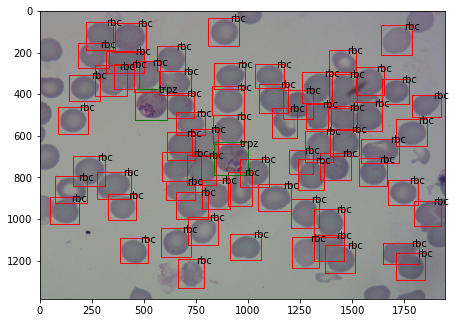

In [20]:
#https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

image = plt.imread('images/deab75c9-00bc-488c-8b20-ff4515d85212.jpg')
plt.imshow(image)


for _,row in test[test.pathname=="/images/deab75c9-00bc-488c-8b20-ff4515d85212.jpg"].iterrows():
    xmin = row.bbminC
    xmax = row.bbmaxC
    ymin = row.bbminR
    ymax = row.bbmaxR
    
    
    l = xmax-xmin
    b = ymax-ymin
           
    if row.category=='red blood cell':
      color='r'
      ax.annotate('rbc',xy=(xmax-40,ymin+20))
    elif row.category=='trophozoite':
      color='g'
      ax.annotate('trpz',xy=(xmax-40,ymin+20))
    elif row.category=='difficult':
      color='b'
      ax.annotate('dfct',xy=(xmax-40,ymin+20))
    elif row.category=='ring':
      color='r'
      ax.annotate('ring',xy=(xmax-40,ymin+20))
    elif row.category=='schizont':
      color='r'
      ax.annotate('sznt',xy=(xmax-40,ymin+20))
    elif row.category==6:
      color='gametocyte'
      ax.annotate('gmct',xy=(xmax-40,ymin+20))
    elif row.category==5:
      color='leukocyte'
      ax.annotate('lkct',xy=(xmax-40,ymin+20))
    
    
    rect = patches.Rectangle((xmin,ymin), l, b, edgecolor = color, facecolor = 'none')
    ax.add_patch(rect)

#### Extracting train images from images folder

In [59]:
files=(train['pathname'].map(lambda x: x.replace('/images/',""))).unique()
print(len(files))

1208


In [64]:
#separating byte files and asm files 
import os
import shutil

source = 'images/'
destination = 'train_images'

# we will check if the folder 'byteFiles' exists if it not there we will create a folder with the same name
if not os.path.isdir(destination):
    os.makedirs(destination)

# if we have folder called 'train' (train folder contains both .asm files and .bytes files) we will rename it 'asmFiles'
# for every file that we have in our 'asmFiles' directory we check if it is ending with .bytes, if yes we will move it to
# 'byteFiles' folder

# so by the end of this snippet we will separate all the .byte files and .asm files
if os.path.isdir(source):
    data_files = os.listdir(source)
    for file in files:  
        if file in data_files:
            #print(source+file)
            shutil.move(source+file,destination)

#### Creating Annotation txt files from csv files

In [2]:
import imagesize
base_path = 'Dataset/Open Images Dataset v4 (Bounding Boxes)'


train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
print(train_df.head())

train_df['FileName'] = train_df['pathname'].map(lambda x: x.replace('/images/',""))

# For training
f= open(base_path + "/train_annotations.txt","w+")
for idx, row in train_df.iterrows():
    sys.stdout.write(str(idx) + '\r')
    sys.stdout.flush()
    img = imagesize.get((base_path + '/train/' + row['FileName']))
    #print(base_path + '/train/' + row['FileName'])
    #print(img)
    height, width = img[:2]
    
    x1 = int(row['bbminC'])
    x2 = int(row['bbmaxC'])
    y1 = int(row['bbminR'])
    y2 = int(row['bbmaxR'])
    
    google_colab_file_path = 'Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
    fileName = os.path.join(google_colab_file_path, row['FileName'])
    className = row['category']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')
f.close()

                           checksum  \
0  676bb8e86fc2dbf05dd97d51a64ac0af   
1  676bb8e86fc2dbf05dd97d51a64ac0af   
2  676bb8e86fc2dbf05dd97d51a64ac0af   
3  676bb8e86fc2dbf05dd97d51a64ac0af   
4  676bb8e86fc2dbf05dd97d51a64ac0af   

                                           pathname  shapeR  shapeC  channels  \
0  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
1  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
2  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
3  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   
4  /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png    1200    1600         3   

   bbminR  bbminC  bbmaxR  bbmaxC        category  
0    1057    1440    1158    1540  red blood cell  
1     868    1303     971    1403  red blood cell  
2     578     900     689    1008  red blood cell  
3     304     611     408     713  red blood cell  
4     198     881 

In [3]:
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

print(test_df.head())

test_df['FileName'] = test_df['pathname'].map(lambda x: x.replace('/images/',""))

# For test
f= open(base_path + "/test_annotations.txt","w+")
for idx, row in test_df.iterrows():
    sys.stdout.write(str(idx) + '\r')
    sys.stdout.flush()
    #print(type(row['FileName']))
    #print(type(row['bbminC']))
    img = imagesize.get((base_path + '/test/' + row['FileName']))
    #print(img)
    height, width = img[:2]    

    x1 = int(row['bbminC'])
    x2 = int(row['bbmaxC'])
    y1 = int(row['bbminR'])
    y2 = int(row['bbmaxR'])
    
    google_colab_file_path = 'Dataset/Open Images Dataset v4 (Bounding Boxes)/test'
    fileName = os.path.join(google_colab_file_path, row['FileName'])
    className = row['category']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')
f.close()

                           checksum  \
0  eea3bfd6a929bcb06f9786667cd3fbb2   
1  eea3bfd6a929bcb06f9786667cd3fbb2   
2  eea3bfd6a929bcb06f9786667cd3fbb2   
3  eea3bfd6a929bcb06f9786667cd3fbb2   
4  eea3bfd6a929bcb06f9786667cd3fbb2   

                                           pathname  shapeR  shapeC  channels  \
0  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
1  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
2  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
3  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   
4  /images/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg    1383    1944         3   

   bbminR  bbminC  bbmaxR  bbmaxC        category  
0     576    1744     708    1883  red blood cell  
1     863    1249     977    1373  red blood cell  
2     210    1573     335    1711  red blood cell  
3    1017    1124    1142    1253  red blood cell  
4     572    1655 

### Summary

1. Data is provided in JSON formats for train and test. Extracted the data and created train and test csv files.
2. Data consists of 
    a. Checksum - ID
    
    b. pathame - path of the image 
    
    c. ShapeR - shapeR of the image
    
    d. ShapeC - ShapeC of the image
    
    e. channels - channels of the image
    
    f. bbminR - bounding box co-ordinates minR
    
    g. bbminC - bounding box co-ordinates minC
    
    h. bbmaxR - bounding box co-ordinates maxR
    
    i. bbmaxC - bounding box co-ordinates maxC
    
    j. category - class of the objects in the image
    
3. For detecting objects in an image using Faster-RCNN object detection method, we need to convert the csv file to an annotation text format which will have filename,bbminR,bbminC,bbmaxR,bbmaxC,category.
4. Using the above method we extract required columns from train and test csv files as train_annotation.txt test_annotation.txt files.